<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap08/8_1_MNIST_1D_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 8.1: MNIST_1D_Performance**

This notebook runs a simple neural network on the MNIST1D dataset as in figure 8.2a. It uses code from https://github.com/greydanus/mnist1d to generate the data.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [65]:
# Run this if you're in a Colab to make a local copy of the MNIST 1D repository
# !git clone https://github.com/greydanus/mnist1d

# Use the preferred installation method
!python -m pip install mnist1d
!python -m pip install torch

56601.54s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
56608.24s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [66]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d

In [67]:
from pathlib import Path
Path('./sample_data').mkdir(parents=True, exist_ok=True) 

Let's generate a training and test dataset using the MNIST1D code.  The dataset gets saved as a .pkl file so it doesn't have to be regenerated each time.

In [68]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./sample_data/mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Successfully loaded data from ./sample_data/mnist1d_data.pkl
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [69]:
D_i = 40    # Input dimensions
D_k = 10   # Hidden dimensions
D_o = 10    # Output dimensions

# Define a model with two hidden layers of size 100
# And ReLU activations between them
# Replace this line (see Figure 7.8 of book for help):
model = torch.nn.Sequential(
  torch.nn.Linear(D_i, D_k),
  torch.nn.ReLU(),
  torch.nn.Linear(D_k, D_k),
  torch.nn.ReLU(),
  torch.nn.Linear(D_k, D_k),
  torch.nn.ReLU(),
  torch.nn.Linear(D_k, D_o));


def weights_init(layer_in):
  # Initialize the parameters with He initialization
  # Replace this line (see figure 7.8 of book for help)
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_normal_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)


# Call the function you just defined
model.apply(weights_init)


Sequential(
  (0): Linear(in_features=40, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=10, bias=True)
)

In [70]:
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.4)
# create 100 dummy data points and store in data loader class
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('long'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('long'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=150, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

Epoch     0, train loss 2.055698, train error 78.28,  test loss 2.042080, test error 78.60
Epoch     1, train loss 1.836912, train error 72.70,  test loss 1.834630, test error 75.50
Epoch     2, train loss 1.685366, train error 69.20,  test loss 1.711236, test error 70.80
Epoch     3, train loss 1.618576, train error 67.03,  test loss 1.636759, test error 67.30
Epoch     4, train loss 1.522463, train error 61.40,  test loss 1.526780, test error 62.70
Epoch     5, train loss 1.426652, train error 57.42,  test loss 1.437770, test error 57.70
Epoch     6, train loss 1.392850, train error 56.65,  test loss 1.409281, test error 58.20
Epoch     7, train loss 1.346627, train error 54.05,  test loss 1.372313, test error 56.30
Epoch     8, train loss 1.346152, train error 54.75,  test loss 1.367520, test error 55.70
Epoch     9, train loss 1.380273, train error 56.78,  test loss 1.409438, test error 58.70
Epoch    10, train loss 1.283269, train error 51.12,  test loss 1.324672, test error 54.20

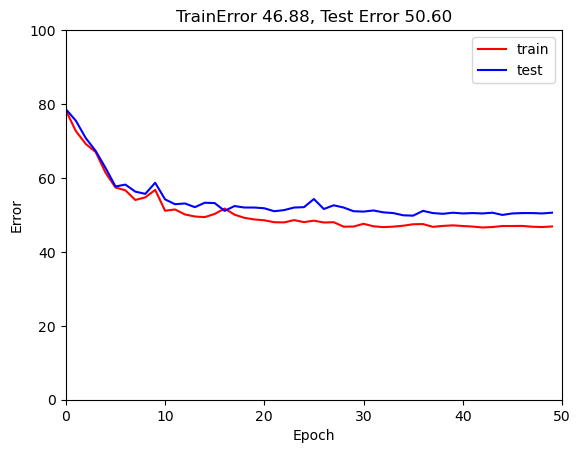

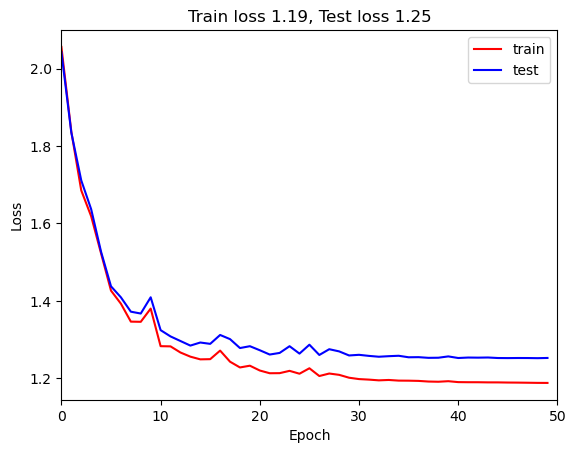

In [71]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show()

**TO DO**

Play with the model -- try changing the number of layers, hidden units, learning rate, batch size, momentum or anything else you like.  See if you can improve the test results.

Is it a good idea to optimize the hyperparameters in this way?  Will the final result be a good estimate of the true test performance?